## Testing Reading Files
This Notebook will demonstrate how I will extract all of the sources rom a fits file and create cutouts from them using the fits WCS and the HSC. This is one of two ways that I could potentially start scanning the archive. 

In [31]:
from zoobot.tensorflow.data_utils import image_datasets
from zoobot.tensorflow.estimators import preprocess, define_model
from zoobot.tensorflow.predictions import predict_on_dataset

from astroquery.mast import Catalogs

from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uuid
import io
import os
import ast
import shutil
from tqdm import tqdm
import sys
from joblib import Parallel, delayed
import glob
import random

import tensorflow as tf
from tensorflow.keras import layers

## Loading in Zoobot Model

In [2]:
initial_size = 300
crop_size = int(0.75 * initial_size)
resize_size = 224
pretrained_checkpoint = 'C:/Users/oryan/Documents/zoobot_new/pretrained-models/replicated_train_only_greyscale_tf/replicated_train_only_greyscale_tf/checkpoint'
finetuned_loc = 'C:/Users/oryan/Documents/zoobot_new/model-logs/2022-05-05-HEC-all-unfrozen-0.89/finetuned/checkpoint'

In [3]:
base_model = define_model.load_model(
    pretrained_checkpoint,
    include_top = False,
    input_size = initial_size,
    crop_size = crop_size,
    resize_size = resize_size,
    output_dim = None,
    channels = 1,
    expect_partial = True
)

In [4]:
para_relu = layers.PReLU()

In [5]:
## Note, this must be identical to how the model was trained!!!
model_head = tf.keras.Sequential([
    layers.InputLayer(input_shape=(7,7,1280)),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64,activation=para_relu),
        #layers.Dropout(0.75),
        layers.Dense(64,activation='elu'),
        layers.Dropout(0.25),
        layers.Dense(64,activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(64,activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(64,activation = para_relu),
        layers.Dropout(0.25),
        layers.Dense(1,activation='sigmoid',name='sigmoid_output')
])

In [6]:
model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(initial_size, initial_size,1)),
        base_model,
        model_head
    ])

In [7]:
model.load_weights(finetuned_loc).expect_partial()

Process:

    1. Load in the Fits file
    2. Extract the WCS and get a footprint/region from it.
    3. Query the HSC for this region. Have cutouts of every object!

In [8]:
file = 'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/AHZ2000a03/mastDownload/HST/hst_10092_0g_acs_wfc_f814w_j8xi0g/hst_10092_0g_acs_wfc_f814w_j8xi0g_drc.fits'

In [9]:
with fits.open(file) as hdul:
    wcs = WCS(hdul[1].header)
    data = hdul[1].data

In [10]:
region = WCS.calc_footprint(wcs)

In [11]:
central_coord = wcs.pixel_to_world(int(data.shape[0]/2), int(data.shape[1]/2))

In [12]:
catalogue_data = Catalogs.query_region(central_coord,radius = 0.05, catalog="HSC")

In [13]:
print(len(catalogue_data))

1649


In [14]:
ra = catalogue_data['MatchRA']
dec = catalogue_data['MatchDec']
matchid = catalogue_data['MatchID']

In [15]:
coords = {}
for i in range(len(ra)):
    coord = SkyCoord(ra = ra[i] * u.deg, dec = dec[i] * u.deg, frame='icrs')
    if wcs.footprint_contains(coord):
        coords[matchid[i]] = coord

In [29]:
def test_func(data, wcs, coords):
    sample_list = list(coords)
    counter = 0
    bad_count = 0
    while counter < 10:
        sample_coord = coords[random.choice(sample_list)]
        try:
            cutout = Cutout2D(data,sample_coord,(150,150),wcs=wcs,mode='strict')
        except:
            continue
        if np.isnan(np.max(cutout.data)):
            continue
        elif np.max(cutout.data) > 5:
            counter += 1
            bad_count += 1
        elif np.max(cutout.data) <= 5:
            counter += 1
    
    if bad_count >= 8:
        return True
    else:
        return False

In [32]:
%%time
test_func(data, wcs, coords)

Wall time: 66.4 ms


False

In [16]:
print(len(catalogue_data))
print(len(coords))

1649
1040


In [18]:
pixels = np.zeros([len(coords),2])
counter = 0
for i in list(coords.keys()):
    pixel_coords = wcs.world_to_pixel(coords[i])
    pixels[counter,0] = pixel_coords[0]
    pixels[counter,1] = pixel_coords[1]
    counter += 1

In [19]:
data.shape

(4927, 5088)

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(np.log10(data))
for i in range(len(pixels)):
    plt.scatter(pixels[i,0],pixels[i,1],color='red',marker='.')

Error in callback <function flush_figures at 0x0000024B9816FB88> (for post_execute):


KeyboardInterrupt: 

Must now create the cutouts and see what we're looking at!

In [21]:
save_folder = 'C:/Users/oryan/Documents/esac-project/cutouts/tmp'

In [22]:
global data, save_folder

In [23]:
def get_url(ra, dec, filename, size, output_size):
    base = 'https://hla.stsci.edu/cgi-bin/fitscut.cgi?'
    url = f'{base}red={filename}&RA={ra}&Dec={dec}&size={size}&output_size={output_size}&format=PNG'
    return url

In [24]:
def get_image(url):
    r = requests.get(url)
    im = Image.open(io.BytesIO(r.content))
    return im

In [25]:
def create_cutout(coord, matchid):
    try:
        cutout = Cutout2D(data,coord,(150,150),wcs=wcs,mode='strict')
    except:
        return
    tmp = len(cutout.data[np.isnan(cutout.data)])
    if tmp > 10:
        return
    else:
        norm = ImageNormalize(
        cutout.data,
        interval=ZScaleInterval(nsamples=5000,contrast = 0.05),
        stretch=LinearStretch(),
        clip=True
        )

        plt.figure()
        plt.imshow(cutout.data,cmap='Greys_r',norm=norm)
        plt.axis('off')
        figure = plt.gcf()
        figure.set_size_inches(4,4)
        plt.savefig(f'{save_folder}/{matchid}.jpeg', dpi=100, bbox_inches='tight',pad_inches=0)
        plt.close()

### Checking the Two Methods...

#### Multiprocessing:

In [26]:
test = 1

In [27]:
%%time
tmp = Parallel(n_jobs=2)(delayed(create_cutout)(coords[coord], coord) for coord in tqdm(list(coords.keys())))
del tmp

100%|██████████| 1040/1040 [00:48<00:00, 21.65it/s]


Wall time: 48.4 s


#### Serial

In [ ]:
%%time
for i in tqdm(list(coords.keys())):
    coord = coords[i]
    create_cutout(coord, i)

Time difference is somewhat minimal, but only using two jobs locally. May try to use 5 or 6 on DataLabs

In [28]:
np.asarray(Image.open('C:/Users/oryan/Documents/esac-project/cutouts/tmp/229283.jpeg')).shape

(308, 308, 3)

## Creating Batch Manifest

In [72]:
im_df_tmp = (
    pd.DataFrame(glob.glob(f'{save_folder}/*'))
    .rename(columns={0:'filepath'})
)

im_df = (
    im_df_tmp.assign(matchid = im_df_tmp.filepath.apply(lambda x: os.path.basename(x).replace('.png','')))
)

In [73]:
im_df

,filepath,matchid
0,C:/Users/oryan/Documents/esac-project/cutouts/...,100639958
1,C:/Users/oryan/Documents/esac-project/cutouts/...,100995304
2,C:/Users/oryan/Documents/esac-project/cutouts/...,101342519
3,C:/Users/oryan/Documents/esac-project/cutouts/...,101353515
4,C:/Users/oryan/Documents/esac-project/cutouts/...,101891299
...,...,...
625,C:/Users/oryan/Documents/esac-project/cutouts/...,99539635
626,C:/Users/oryan/Documents/esac-project/cutouts/...,9967834
627,C:/Users/oryan/Documents/esac-project/cutouts/...,99800536
628,C:/Users/oryan/Documents/esac-project/cutouts/...,99883027


## Now, the Predictions...

In [74]:
def image_converter(filepath):
    im = Image.open(filepath)
    im_arr = np.asarray(im)
    if im_arr.shape[-1] == 4:
        im_grey = im.convert('RGB')
        im_grey.save(filepath)
        im_grey.close()
    im.close()

In [29]:
for i in tqdm(im_df.filepath):
    image_converter(i)

100%|██████████| 630/630 [00:13<00:00, 45.61it/s]


In [30]:
initial_size = 300
batch_size = 256
file_format = 'png'

In [31]:
raw_image_ds = image_datasets.get_image_dataset([x for x in im_df.filepath], file_format, initial_size, batch_size)

In [32]:
preprocessing_config = preprocess.PreprocessingConfig(
    label_cols = [],
    input_size = initial_size,
    make_greyscale = True,
    normalise_from_uint8 = True
)

In [33]:
image_ds = preprocess.preprocess_dataset(raw_image_ds, preprocessing_config)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [34]:
n_samples = 1
label_cols = ['interacting']
filename = os.path.splitext(os.path.basename(file))[0]
save_loc = f'C:/Users/oryan/Documents/esac-project/predictions/pred_sources_{filename}.csv'

In [35]:
predictions = predict_on_dataset.predict(image_ds,model,1,label_cols, save_loc, ret_flag=True)

In [36]:
predictions

,id_str,interacting_pred
0,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.999090313911438]
1,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.313776433467865]
2,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.112730473279953]
3,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.07411831617355347]
4,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.9950214624404907]
...,...,...
625,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.07799339294433594]
626,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.9999945759773254]
627,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.18756824731826782]
628,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.09099116921424866]


In [42]:
cut = 0.75

In [43]:
predictions_export = (
    predictions
    .assign(matchid = predictions.id_str.apply(lambda x: os.path.splitext(os.path.basename(x))[0]))
    .assign(binary_prediction = predictions.interacting_pred.apply(lambda x: 1 if ast.literal_eval(x)[0] > cut else 0))
    .rename(columns={'id_str':'file_path'})
)

In [44]:
predictions = pd.read_csv('C:/Users/oryan/Documents/esac-project/predictions/pred_sources_hst_10092_0g_acs_wfc_f814w_j8xi0g_drc.csv')

In [45]:
predictions_export

,file_path,interacting_pred,matchid,binary_prediction
0,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.999090313911438],100639958,1
1,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.313776433467865],100995304,0
2,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.112730473279953],101342519,0
3,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.07411831617355347],101353515,0
4,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.9950214624404907],101891299,1
...,...,...,...,...
625,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.07799339294433594],99539635,0
626,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.9999945759773254],9967834,1
627,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.18756824731826782],99800536,0
628,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.09099116921424866],99883027,0


In [46]:
predictions_export.binary_prediction.value_counts()

0    575
1     55
Name: binary_prediction, dtype: int64

In [48]:
interactors = predictions_export.query('binary_prediction == 1')

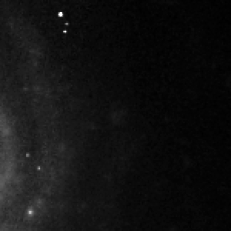

In [73]:
Image.open(interactors.file_path.iloc[25])

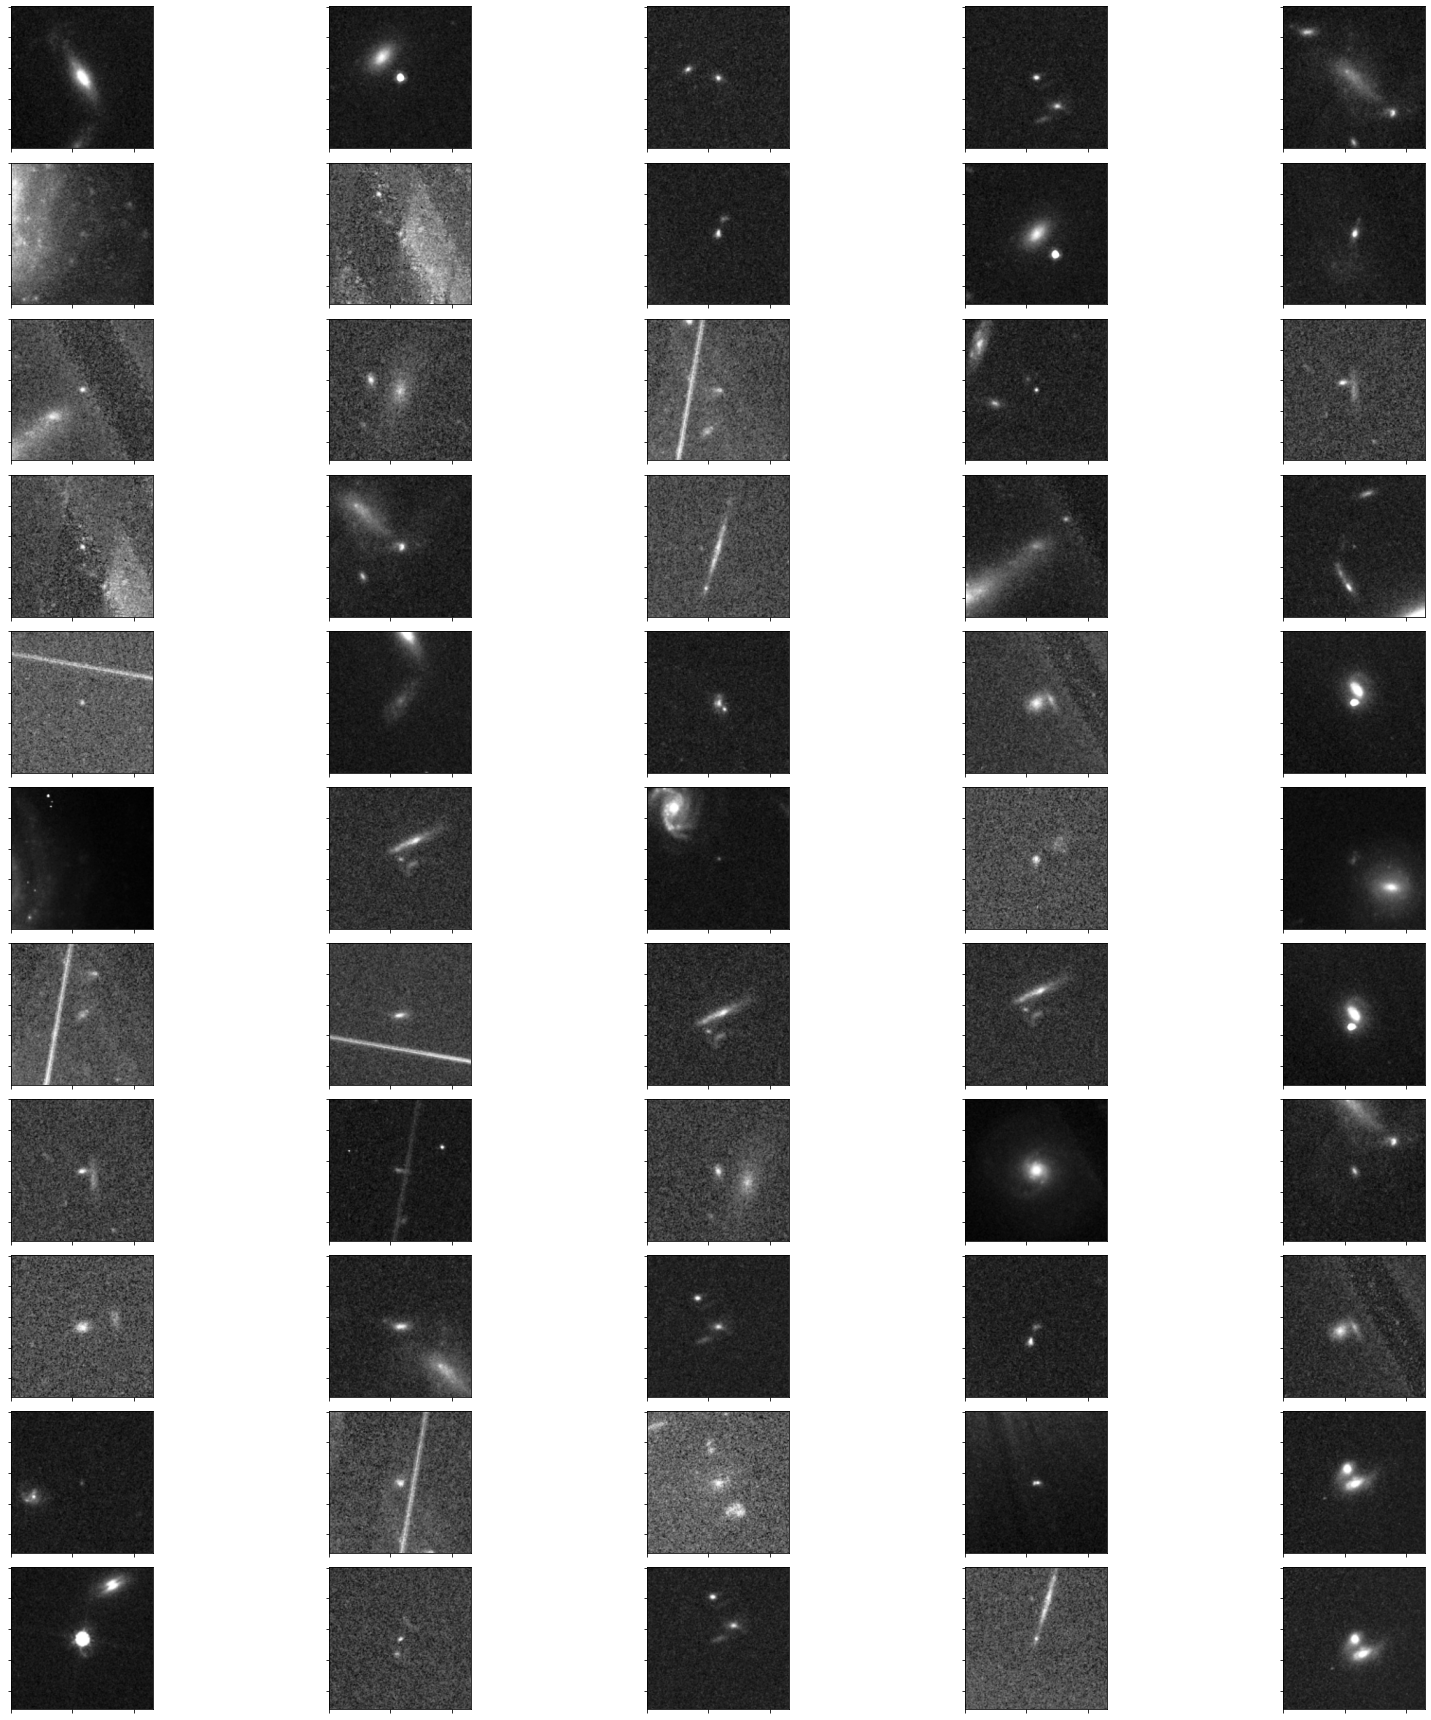

In [92]:
counter = 0

fig, ax = plt.subplots(nrows=11,ncols=5,figsize=(24,24))
for i in range(11):
    for j in range(5):
        im = Image.open(interactors.file_path.iloc[counter])
        ax[i,j].imshow(im)
        ax[i,j].set_xticklabels(())
        ax[i,j].set_yticklabels(())
        counter += 1
fig.tight_layout()